In [20]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [21]:
import numpy as np

In [22]:
from tidaldisruptionlrd import eddington_inversion
from tidaldisruptionlrd.constants import G

In [23]:
import importlib

importlib.reload(eddington_inversion)

<module 'tidaldisruptionlrd.eddington_inversion' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/eddington_inversion.py'>

In [29]:
class IsothermalSphereProfile(eddington_inversion.BaseProfile):
    def __init__(
        self, M_bh, sigma, r_bin_min_scaler=1e-3, r_bin_max_scaler=1e4, N_bins=10000
    ):
        self.sigma = sigma
        self.r_h = G * M_bh / sigma**2
        super().__init__(
            r_bin_min=r_bin_min_scaler * self.r_h,
            r_bin_max=r_bin_max_scaler * self.r_h,
            N_bins=N_bins,
            M_bh=M_bh,
        )

    def _get_stellar_rho_bins(self, r_bins):
        return self.sigma**2 / (2 * np.pi * G * r_bins**2)

In [30]:
isothermal_sphere = IsothermalSphereProfile(M_bh=1e6, sigma=100)

Eddington's inversion: 100%|██████████| 9999/9999 [00:14<00:00, 686.02it/s]


In [31]:
reconstructed_stellar_rho_bins = isothermal_sphere.reconstruct_stellar_rho_bins()

/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/eddington_inversion.py:240: RuntimeWarning: divide by zero encountered in log
  Array of Eddington distribution probability bins in (km/s)^-2.
Reconstructing densities: 100%|██████████| 10000/10000 [00:07<00:00, 1306.14it/s]


/var/folders/_n/k8j9__0s4x1b10rq7h7zj1bc0000gq/T/ipykernel_18096/2022990205.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


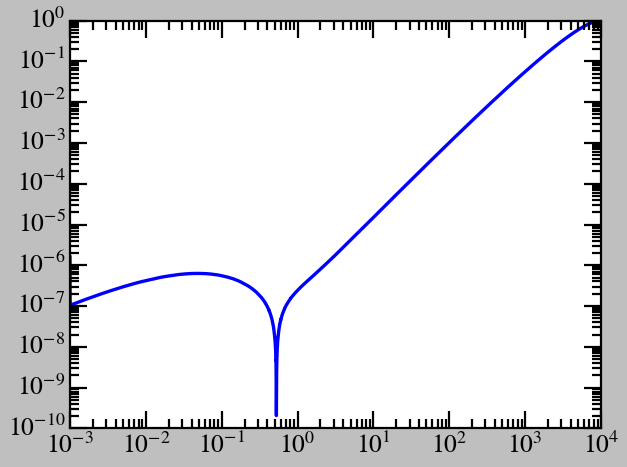

In [ ]:
r_bins = isothermal_sphere.r_bins
r_h = isothermal_sphere.r_h
analytic_stellar_rho_bins = isothermal_sphere.stellar_rho_bins

plt.plot(
    r_bins / r_h, np.abs(1 - reconstructed_stellar_rho_bins / analytic_stellar_rho_bins)
)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

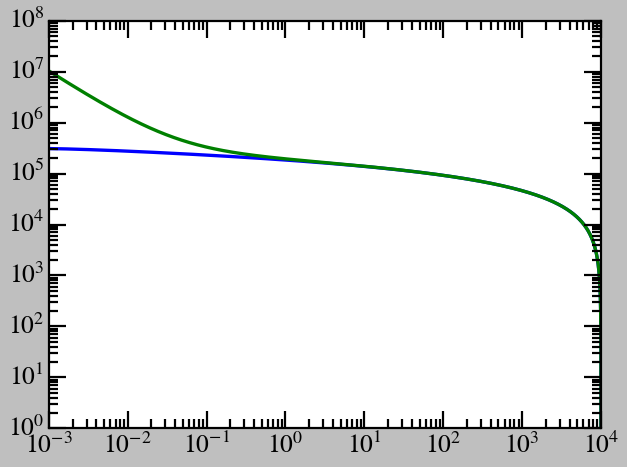

In [39]:
plt.plot(
    isothermal_sphere.r_bins / isothermal_sphere.r_h,
    -isothermal_sphere.stellar_phi_bins,
)
plt.plot(isothermal_sphere.r_bins / isothermal_sphere.r_h, -isothermal_sphere.phi_bins)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()